In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import metrics
import itertools
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper
from sklearn import preprocessing
%matplotlib inline

### *Load Data*

In [2]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [3]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURESALL_WTS = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType", "happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

### *Preprocess data*

In [4]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], None)], input_df = True)

mapper1Hot = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True)

transformedData = pd.DataFrame(mapper.fit_transform(data.copy()), columns=FEATURESALL)
transformedData["FFPType"] = transformedData["FFPType"].astype('int64')

transformedData1Hot = mapper1Hot.fit_transform(data.copy())

In [5]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,scores.index)
transformedData_WTS = pd.concat([transformedData, WTS_df], axis = 1)
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData_WTS, scores, test_size=0.2, random_state=42)

In [7]:
X_trainHot, X_testHot, y_trainHot, y_testHot = model_selection.train_test_split(transformedData1Hot, scores_WTS, test_size=0.2, random_state=42)

### *Define Tensorflow input data processing functions*

In [8]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({'x':{k: data_x[k].values for k in FEATURESALL_WTS}}, index=data_x.index),
      y = pd.Series(data_y[LABEL].values, index= data_x.index),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [9]:
def get_input_fn_numpy(data_x,data_y, data_w,LABEL, num_epochs=None, shuffle=True):
    return tf.estimator.inputs.numpy_input_fn(
        x={'x': data_x, 'w': data_w.values},
        y=data_y[LABEL].values, 
        num_epochs=num_epochs, # repeat forever
        shuffle=shuffle # 
    )

In [10]:
def get_testinput_fn_numpy(data_x,data_y,LABEL, num_epochs=None, shuffle=True):
    return tf.estimator.inputs.numpy_input_fn(
        x={'x': data_x},
        y=data_y[LABEL].values, 
        num_epochs=num_epochs, # repeat forever
        shuffle=shuffle # 
    )

### *Set up DNN architecture and its tuning sweep*

In [11]:
# reference: https://github.com/tensorflow/workshops/blob/master/notebooks/05_custom_estimators.ipynb
def model_fn(features, labels, mode):
    
    # First we'll create 2 fully-connected layers, with ReLU activations.
    # Notice we're retrieving the 'x' feature (we'll provide this in the input function
    # in a moment).
    fc1 = tf.layers.dense(features['x'], HIDDEN1_SIZE, activation=tf.nn.softplus, kernel_regularizer=tf.contrib.layers.l1_regularizer(0.1),
                          name="fc1")
    #fc2 = tf.layers.dense(fc1, HIDDEN2_SIZE, activation=tf.nn.relu, name="fc2")
    
    # Add dropout operation; 0.9 probability that a neuron will be kept
    dropout = tf.layers.dropout(
        inputs=fc1, rate=0.1, training = mode == tf.estimator.ModeKeys.TRAIN, name="dropout")

    # Connect the output layer to second hidden layer (no activation fn)
    output_layer = tf.layers.dense(dropout, 1)
    #output_layer = tf.layers.dense(fc1, 1)
    
    # Reshape output layer to 1-dim Tensor to return predictions
    predictions = tf.reshape(output_layer, [-1])
    predictions_dict = {"score": predictions}
        
    if mode == tf.estimator.ModeKeys.PREDICT:
        # Return an EstimatorSpec for prediction
        return tf.estimator.EstimatorSpec(mode=mode,
            predictions=predictions)
    
    # Compute the loss, per usual.
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        # Compute the loss, per usual.
        loss = tf.losses.mean_squared_error(labels, predictions, weights = features['w'])
    
        # Configure the Training Op
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=0.001,
            optimizer='Adam')

        # Return an EstimatorSpec for training
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                      loss=loss, train_op=train_op)    
    
#     # Calculate root mean squared error as additional eval metric
#     eval_metric_ops = {"rmse": tf.metrics.root_mean_squared_error(
#           tf.cast(labels, tf.float64), predictions, weights = features['w'])}
    
    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    return tf.estimator.EstimatorSpec(mode=mode, 
                                      predictions=predictions, 
                                      loss=loss)#,
                                      #eval_metric_ops=eval_metric_ops)

In [12]:
HIDDEN1_SIZE = 10
#HIDDEN2_SIZE = 10

In [13]:
# At this point, our Estimator will work just like a canned one.
estimator = tf.estimator.Estimator(model_fn=model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_session_config': None, '_log_step_count_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\rutad\\AppData\\Local\\Temp\\tmposz3q6lj'}


In [14]:
# Train the estimator using our input function.
estimator.train(input_fn=get_input_fn_numpy(X_trainHot, y_trainHot, y_trainHot[WT_COL],LABEL, num_epochs=None, shuffle=True),steps=200000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\rutad\AppData\Local\Temp\tmposz3q6lj\model.ckpt.
INFO:tensorflow:loss = 456.449, step = 1
INFO:tensorflow:global_step/sec: 518.106
INFO:tensorflow:loss = 393.389, step = 101 (0.194 sec)
INFO:tensorflow:global_step/sec: 581.362
INFO:tensorflow:loss = 347.341, step = 201 (0.173 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 295.89, step = 301 (0.192 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 208.482, step = 401 (0.186 sec)
INFO:tensorflow:global_step/sec: 495.021
INFO:tensorflow:loss = 197.378, step = 501 (0.206 sec)
INFO:tensorflow:global_step/sec: 526.286
INFO:tensorflow:loss = 152.467, step = 601 (0.187 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 110.122, step = 701 (0.182 sec)
INFO:tensorflow:global_step/sec: 531.885
INFO:tensorflow:loss = 112.428, step = 801 (0.186 sec)
INFO:tensorflow:global_step/sec: 502.483
INF

INFO:tensorflow:global_step/sec: 574.679
INFO:tensorflow:loss = 12.3895, step = 8401 (0.174 sec)
INFO:tensorflow:global_step/sec: 613.462
INFO:tensorflow:loss = 14.1045, step = 8501 (0.164 sec)
INFO:tensorflow:global_step/sec: 609.721
INFO:tensorflow:loss = 13.8383, step = 8601 (0.162 sec)
INFO:tensorflow:global_step/sec: 624.965
INFO:tensorflow:loss = 14.508, step = 8701 (0.160 sec)
INFO:tensorflow:global_step/sec: 719.383
INFO:tensorflow:loss = 17.1018, step = 8801 (0.139 sec)
INFO:tensorflow:global_step/sec: 704.185
INFO:tensorflow:loss = 13.6128, step = 8901 (0.143 sec)
INFO:tensorflow:global_step/sec: 636.906
INFO:tensorflow:loss = 12.4668, step = 9001 (0.156 sec)
INFO:tensorflow:global_step/sec: 632.875
INFO:tensorflow:loss = 9.31578, step = 9101 (0.159 sec)
INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 11.4754, step = 9201 (0.162 sec)
INFO:tensorflow:global_step/sec: 671.103
INFO:tensorflow:loss = 18.168, step = 9301 (0.150 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 609.721
INFO:tensorflow:loss = 15.0126, step = 16801 (0.163 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 10.203, step = 16901 (0.169 sec)
INFO:tensorflow:global_step/sec: 598.768
INFO:tensorflow:loss = 10.0754, step = 17001 (0.168 sec)
INFO:tensorflow:global_step/sec: 591.682
INFO:tensorflow:loss = 12.8458, step = 17101 (0.168 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 14.55, step = 17201 (0.173 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 10.9818, step = 17301 (0.185 sec)
INFO:tensorflow:global_step/sec: 485.409
INFO:tensorflow:loss = 9.6985, step = 17401 (0.207 sec)
INFO:tensorflow:global_step/sec: 502.485
INFO:tensorflow:loss = 13.9594, step = 17501 (0.198 sec)
INFO:tensorflow:global_step/sec: 552.454
INFO:tensorflow:loss = 14.1753, step = 17601 (0.183 sec)
INFO:tensorflow:global_step/sec: 492.583
INFO:tensorflow:loss = 12.5102, step = 17701 (0.203 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 502.483
INFO:tensorflow:loss = 10.428, step = 25201 (0.199 sec)
INFO:tensorflow:global_step/sec: 574.679
INFO:tensorflow:loss = 9.39697, step = 25301 (0.172 sec)
INFO:tensorflow:global_step/sec: 531.885
INFO:tensorflow:loss = 8.34156, step = 25401 (0.189 sec)
INFO:tensorflow:global_step/sec: 552.455
INFO:tensorflow:loss = 9.57231, step = 25501 (0.180 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 14.6634, step = 25601 (0.185 sec)
INFO:tensorflow:global_step/sec: 540.51
INFO:tensorflow:loss = 10.2359, step = 25701 (0.183 sec)
INFO:tensorflow:global_step/sec: 444.419
INFO:tensorflow:loss = 11.5714, step = 25801 (0.225 sec)
INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 8.53209, step = 25901 (0.173 sec)
INFO:tensorflow:global_step/sec: 471.671
INFO:tensorflow:loss = 10.0502, step = 26001 (0.211 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 14.7411, step = 26101 (0.184 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 9.93132, step = 33601 (0.177 sec)
INFO:tensorflow:global_step/sec: 568.149
INFO:tensorflow:loss = 8.12335, step = 33701 (0.171 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 9.7661, step = 33801 (0.193 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 9.12454, step = 33901 (0.183 sec)
INFO:tensorflow:global_step/sec: 578.001
INFO:tensorflow:loss = 10.479, step = 34001 (0.173 sec)
INFO:tensorflow:global_step/sec: 606.027
INFO:tensorflow:loss = 9.70321, step = 34101 (0.166 sec)
INFO:tensorflow:global_step/sec: 537.603
INFO:tensorflow:loss = 10.7392, step = 34201 (0.185 sec)
INFO:tensorflow:global_step/sec: 568.15
INFO:tensorflow:loss = 7.79995, step = 34301 (0.176 sec)
INFO:tensorflow:global_step/sec: 662.214
INFO:tensorflow:loss = 9.2571, step = 34401 (0.151 sec)
INFO:tensorflow:global_step/sec: 609.721
INFO:tensorflow:loss = 9.65988, step = 34501 (0.167 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 624.964
INFO:tensorflow:loss = 9.74126, step = 42001 (0.162 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 10.0123, step = 42101 (0.178 sec)
INFO:tensorflow:global_step/sec: 591.682
INFO:tensorflow:loss = 8.24697, step = 42201 (0.170 sec)
INFO:tensorflow:global_step/sec: 552.455
INFO:tensorflow:loss = 8.12925, step = 42301 (0.182 sec)
INFO:tensorflow:global_step/sec: 564.939
INFO:tensorflow:loss = 10.5364, step = 42401 (0.177 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 9.69406, step = 42501 (0.179 sec)
INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 7.95614, step = 42601 (0.171 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 9.80366, step = 42701 (0.184 sec)
INFO:tensorflow:global_step/sec: 591.682
INFO:tensorflow:loss = 10.9473, step = 42801 (0.169 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 8.39532, step = 42901 (0.186 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 485.409
INFO:tensorflow:loss = 9.44036, step = 50401 (0.206 sec)
INFO:tensorflow:global_step/sec: 502.483
INFO:tensorflow:loss = 9.72534, step = 50501 (0.198 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 8.68469, step = 50601 (0.183 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 10.5698, step = 50701 (0.188 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:loss = 8.5613, step = 50801 (0.207 sec)
INFO:tensorflow:global_step/sec: 507.585
INFO:tensorflow:loss = 10.301, step = 50901 (0.195 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 10.1976, step = 51001 (0.190 sec)
INFO:tensorflow:global_step/sec: 584.762
INFO:tensorflow:loss = 9.38847, step = 51101 (0.170 sec)
INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:loss = 8.45023, step = 51201 (0.202 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 9.1296, step = 51301 (0.186 sec)
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 8.27097, step = 58801 (0.172 sec)
INFO:tensorflow:global_step/sec: 606.026
INFO:tensorflow:loss = 9.32586, step = 58901 (0.166 sec)
INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 10.7192, step = 59001 (0.171 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 9.31095, step = 59101 (0.181 sec)
INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 10.765, step = 59201 (0.178 sec)
INFO:tensorflow:global_step/sec: 588.201
INFO:tensorflow:loss = 10.4104, step = 59301 (0.170 sec)
INFO:tensorflow:global_step/sec: 520.804
INFO:tensorflow:loss = 8.66894, step = 59401 (0.192 sec)
INFO:tensorflow:global_step/sec: 552.455
INFO:tensorflow:loss = 8.03638, step = 59501 (0.180 sec)
INFO:tensorflow:global_step/sec: 558.627
INFO:tensorflow:loss = 8.15441, step = 59601 (0.180 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 8.66595, step = 59701 (0.178 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 7.93661, step = 67201 (0.176 sec)
INFO:tensorflow:global_step/sec: 581.362
INFO:tensorflow:loss = 8.20888, step = 67301 (0.172 sec)
INFO:tensorflow:global_step/sec: 568.149
INFO:tensorflow:loss = 9.63816, step = 67401 (0.176 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 9.51613, step = 67501 (0.186 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 8.17038, step = 67601 (0.170 sec)
INFO:tensorflow:global_step/sec: 552.455
INFO:tensorflow:loss = 9.21673, step = 67701 (0.179 sec)
INFO:tensorflow:global_step/sec: 561.765
INFO:tensorflow:loss = 11.1812, step = 67801 (0.179 sec)
INFO:tensorflow:global_step/sec: 505.021
INFO:tensorflow:loss = 9.49461, step = 67901 (0.198 sec)
INFO:tensorflow:global_step/sec: 515.435
INFO:tensorflow:loss = 10.234, step = 68001 (0.193 sec)
INFO:tensorflow:global_step/sec: 621.082
INFO:tensorflow:loss = 8.80704, step = 68101 (0.162 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 549.42
INFO:tensorflow:loss = 8.11542, step = 75601 (0.181 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 7.84703, step = 75701 (0.183 sec)
INFO:tensorflow:global_step/sec: 588.201
INFO:tensorflow:loss = 6.8778, step = 75801 (0.169 sec)
INFO:tensorflow:global_step/sec: 568.149
INFO:tensorflow:loss = 8.0509, step = 75901 (0.176 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 8.0957, step = 76001 (0.182 sec)
INFO:tensorflow:global_step/sec: 568.15
INFO:tensorflow:loss = 8.53743, step = 76101 (0.177 sec)
INFO:tensorflow:global_step/sec: 450.425
INFO:tensorflow:loss = 7.33676, step = 76201 (0.222 sec)
INFO:tensorflow:global_step/sec: 558.628
INFO:tensorflow:loss = 9.21581, step = 76301 (0.180 sec)
INFO:tensorflow:global_step/sec: 584.762
INFO:tensorflow:loss = 9.93042, step = 76401 (0.169 sec)
INFO:tensorflow:global_step/sec: 602.375
INFO:tensorflow:loss = 8.51927, step = 76501 (0.166 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 7.57021, step = 84001 (0.172 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 8.20574, step = 84101 (0.169 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 8.58056, step = 84201 (0.181 sec)
INFO:tensorflow:global_step/sec: 609.721
INFO:tensorflow:loss = 6.96938, step = 84301 (0.165 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 9.516, step = 84401 (0.192 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 7.30699, step = 84501 (0.177 sec)
INFO:tensorflow:global_step/sec: 523.53
INFO:tensorflow:loss = 8.38141, step = 84601 (0.188 sec)
INFO:tensorflow:global_step/sec: 568.149
INFO:tensorflow:loss = 9.50332, step = 84701 (0.176 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 10.1812, step = 84801 (0.194 sec)
INFO:tensorflow:global_step/sec: 609.721
INFO:tensorflow:loss = 8.21521, step = 84901 (0.164 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 7.91192, step = 92401 (0.163 sec)
INFO:tensorflow:global_step/sec: 584.762
INFO:tensorflow:loss = 9.1786, step = 92501 (0.170 sec)
INFO:tensorflow:global_step/sec: 584.762
INFO:tensorflow:loss = 7.45957, step = 92601 (0.170 sec)
INFO:tensorflow:global_step/sec: 628.894
INFO:tensorflow:loss = 8.61392, step = 92701 (0.159 sec)
INFO:tensorflow:global_step/sec: 606.027
INFO:tensorflow:loss = 8.33815, step = 92801 (0.165 sec)
INFO:tensorflow:global_step/sec: 588.201
INFO:tensorflow:loss = 9.43769, step = 92901 (0.171 sec)
INFO:tensorflow:global_step/sec: 564.94
INFO:tensorflow:loss = 10.5223, step = 93001 (0.177 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 6.97221, step = 93101 (0.168 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 7.97714, step = 93201 (0.173 sec)
INFO:tensorflow:global_step/sec: 561.765
INFO:tensorflow:loss = 6.74153, step = 93301 (0.178 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 602.375
INFO:tensorflow:loss = 9.08624, step = 100801 (0.165 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 8.6653, step = 100901 (0.175 sec)
INFO:tensorflow:global_step/sec: 613.462
INFO:tensorflow:loss = 8.64896, step = 101001 (0.162 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 9.90446, step = 101101 (0.180 sec)
INFO:tensorflow:global_step/sec: 606.027
INFO:tensorflow:loss = 7.90205, step = 101201 (0.166 sec)
INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 7.53084, step = 101301 (0.175 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 9.82749, step = 101401 (0.166 sec)
INFO:tensorflow:global_step/sec: 628.895
INFO:tensorflow:loss = 10.2653, step = 101501 (0.159 sec)
INFO:tensorflow:global_step/sec: 543.447
INFO:tensorflow:loss = 9.11917, step = 101601 (0.185 sec)
INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 8.03893, step = 101701 (0.174 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 454.519
INFO:tensorflow:loss = 8.37066, step = 109101 (0.221 sec)
INFO:tensorflow:global_step/sec: 420.144
INFO:tensorflow:loss = 6.73555, step = 109201 (0.237 sec)
INFO:tensorflow:global_step/sec: 499.971
INFO:tensorflow:loss = 7.84077, step = 109301 (0.200 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:loss = 8.15265, step = 109401 (0.209 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 7.42678, step = 109501 (0.186 sec)
INFO:tensorflow:global_step/sec: 423.704
INFO:tensorflow:loss = 9.92395, step = 109601 (0.237 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 9.77191, step = 109701 (0.185 sec)
INFO:tensorflow:global_step/sec: 531.885
INFO:tensorflow:loss = 8.68715, step = 109801 (0.188 sec)
INFO:tensorflow:global_step/sec: 649.313
INFO:tensorflow:loss = 6.65624, step = 109901 (0.155 sec)
INFO:tensorflow:global_step/sec: 684.892
INFO:tensorflow:loss = 8.11324, step = 110001 (0.145 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 640.989
INFO:tensorflow:loss = 8.31723, step = 117401 (0.157 sec)
INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 9.60675, step = 117501 (0.172 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 7.60866, step = 117601 (0.186 sec)
INFO:tensorflow:global_step/sec: 571.395
INFO:tensorflow:loss = 7.66129, step = 117701 (0.175 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 9.59398, step = 117801 (0.181 sec)
INFO:tensorflow:global_step/sec: 558.628
INFO:tensorflow:loss = 7.91118, step = 117901 (0.180 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 7.62576, step = 118001 (0.189 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 9.56154, step = 118101 (0.172 sec)
INFO:tensorflow:global_step/sec: 564.94
INFO:tensorflow:loss = 9.49684, step = 118201 (0.178 sec)
INFO:tensorflow:global_step/sec: 578.002
INFO:tensorflow:loss = 10.4675, step = 118301 (0.172 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:loss = 8.45974, step = 125701 (0.199 sec)
INFO:tensorflow:global_step/sec: 510.175
INFO:tensorflow:loss = 8.38983, step = 125801 (0.199 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 8.41628, step = 125901 (0.191 sec)
INFO:tensorflow:global_step/sec: 515.435
INFO:tensorflow:loss = 7.53884, step = 126001 (0.192 sec)
INFO:tensorflow:global_step/sec: 471.671
INFO:tensorflow:loss = 7.02045, step = 126101 (0.214 sec)
INFO:tensorflow:global_step/sec: 529.071
INFO:tensorflow:loss = 9.50406, step = 126201 (0.189 sec)
INFO:tensorflow:global_step/sec: 564.94
INFO:tensorflow:loss = 8.03161, step = 126301 (0.176 sec)
INFO:tensorflow:global_step/sec: 546.417
INFO:tensorflow:loss = 7.94784, step = 126401 (0.183 sec)
INFO:tensorflow:global_step/sec: 540.509
INFO:tensorflow:loss = 8.52622, step = 126501 (0.184 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 8.90582, step = 126601 (0.187 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 495.021
INFO:tensorflow:loss = 7.67207, step = 134001 (0.202 sec)
INFO:tensorflow:global_step/sec: 480.742
INFO:tensorflow:loss = 6.3941, step = 134101 (0.209 sec)
INFO:tensorflow:global_step/sec: 490.168
INFO:tensorflow:loss = 8.16878, step = 134201 (0.203 sec)
INFO:tensorflow:global_step/sec: 510.175
INFO:tensorflow:loss = 8.01471, step = 134301 (0.196 sec)
INFO:tensorflow:global_step/sec: 497.484
INFO:tensorflow:loss = 6.40134, step = 134401 (0.202 sec)
INFO:tensorflow:global_step/sec: 478.441
INFO:tensorflow:loss = 6.59696, step = 134501 (0.208 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 10.4148, step = 134601 (0.179 sec)
INFO:tensorflow:global_step/sec: 499.972
INFO:tensorflow:loss = 8.62663, step = 134701 (0.202 sec)
INFO:tensorflow:global_step/sec: 549.419
INFO:tensorflow:loss = 8.34361, step = 134801 (0.184 sec)
INFO:tensorflow:global_step/sec: 473.906
INFO:tensorflow:loss = 8.21164, step = 134901 (0.208 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 8.35427, step = 142301 (0.171 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 7.72017, step = 142401 (0.189 sec)
INFO:tensorflow:global_step/sec: 564.939
INFO:tensorflow:loss = 9.7668, step = 142501 (0.177 sec)
INFO:tensorflow:global_step/sec: 505.022
INFO:tensorflow:loss = 6.61019, step = 142601 (0.200 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 6.69171, step = 142701 (0.184 sec)
INFO:tensorflow:global_step/sec: 502.483
INFO:tensorflow:loss = 7.56328, step = 142801 (0.198 sec)
INFO:tensorflow:global_step/sec: 555.524
INFO:tensorflow:loss = 7.61955, step = 142901 (0.180 sec)
INFO:tensorflow:global_step/sec: 432.876
INFO:tensorflow:loss = 8.68277, step = 143001 (0.232 sec)
INFO:tensorflow:global_step/sec: 526.285
INFO:tensorflow:loss = 6.76572, step = 143101 (0.190 sec)
INFO:tensorflow:global_step/sec: 505.022
INFO:tensorflow:loss = 8.70665, step = 143201 (0.198 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 436.656
INFO:tensorflow:loss = 5.79318, step = 150601 (0.226 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 5.65739, step = 150701 (0.187 sec)
INFO:tensorflow:global_step/sec: 438.572
INFO:tensorflow:loss = 8.11173, step = 150801 (0.227 sec)
INFO:tensorflow:global_step/sec: 462.936
INFO:tensorflow:loss = 6.6263, step = 150901 (0.217 sec)
INFO:tensorflow:global_step/sec: 523.53
INFO:tensorflow:loss = 8.80189, step = 151001 (0.189 sec)
INFO:tensorflow:global_step/sec: 534.729
INFO:tensorflow:loss = 8.77877, step = 151101 (0.189 sec)
INFO:tensorflow:global_step/sec: 460.803
INFO:tensorflow:loss = 6.74797, step = 151201 (0.217 sec)
INFO:tensorflow:global_step/sec: 495.021
INFO:tensorflow:loss = 8.42487, step = 151301 (0.201 sec)
INFO:tensorflow:global_step/sec: 531.885
INFO:tensorflow:loss = 7.17163, step = 151401 (0.188 sec)
INFO:tensorflow:global_step/sec: 515.435
INFO:tensorflow:loss = 9.05134, step = 151501 (0.194 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 8.80006, step = 158901 (0.190 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 8.72219, step = 159001 (0.168 sec)
INFO:tensorflow:global_step/sec: 628.895
INFO:tensorflow:loss = 10.3911, step = 159101 (0.159 sec)
INFO:tensorflow:global_step/sec: 507.585
INFO:tensorflow:loss = 7.4777, step = 159201 (0.198 sec)
INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 8.21321, step = 159301 (0.162 sec)
INFO:tensorflow:global_step/sec: 462.936
INFO:tensorflow:loss = 8.95066, step = 159401 (0.214 sec)
INFO:tensorflow:global_step/sec: 429.16
INFO:tensorflow:loss = 7.17869, step = 159501 (0.234 sec)
INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 6.30226, step = 159601 (0.167 sec)
INFO:tensorflow:global_step/sec: 561.765
INFO:tensorflow:loss = 8.23612, step = 159701 (0.178 sec)
INFO:tensorflow:global_step/sec: 537.604
INFO:tensorflow:loss = 8.68876, step = 159801 (0.186 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 460.803
INFO:tensorflow:loss = 7.40365, step = 167201 (0.213 sec)
INFO:tensorflow:global_step/sec: 413.199
INFO:tensorflow:loss = 7.74627, step = 167301 (0.243 sec)
INFO:tensorflow:global_step/sec: 515.435
INFO:tensorflow:loss = 7.64127, step = 167401 (0.192 sec)
INFO:tensorflow:global_step/sec: 540.509
INFO:tensorflow:loss = 8.19774, step = 167501 (0.185 sec)
INFO:tensorflow:global_step/sec: 531.885
INFO:tensorflow:loss = 6.67842, step = 167601 (0.187 sec)
INFO:tensorflow:global_step/sec: 452.463
INFO:tensorflow:loss = 10.0099, step = 167701 (0.222 sec)
INFO:tensorflow:global_step/sec: 507.585
INFO:tensorflow:loss = 7.01384, step = 167801 (0.198 sec)
INFO:tensorflow:global_step/sec: 485.409
INFO:tensorflow:loss = 9.10766, step = 167901 (0.207 sec)
INFO:tensorflow:global_step/sec: 452.463
INFO:tensorflow:loss = 7.50809, step = 168001 (0.218 sec)
INFO:tensorflow:global_step/sec: 343.623
INFO:tensorflow:loss = 8.00255, step = 168101 (0.293 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 595.204
INFO:tensorflow:loss = 8.76053, step = 175501 (0.168 sec)
INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 8.71778, step = 175601 (0.162 sec)
INFO:tensorflow:global_step/sec: 543.447
INFO:tensorflow:loss = 7.69025, step = 175701 (0.183 sec)
INFO:tensorflow:global_step/sec: 497.484
INFO:tensorflow:loss = 8.31655, step = 175801 (0.203 sec)
INFO:tensorflow:global_step/sec: 628.894
INFO:tensorflow:loss = 7.54723, step = 175901 (0.158 sec)
INFO:tensorflow:global_step/sec: 613.462
INFO:tensorflow:loss = 10.3782, step = 176001 (0.162 sec)
INFO:tensorflow:global_step/sec: 613.462
INFO:tensorflow:loss = 7.33903, step = 176101 (0.164 sec)
INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 8.01801, step = 176201 (0.162 sec)
INFO:tensorflow:global_step/sec: 617.249
INFO:tensorflow:loss = 8.58318, step = 176301 (0.162 sec)
INFO:tensorflow:global_step/sec: 621.082
INFO:tensorflow:loss = 8.56169, step = 176401 (0.161 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 602.375
INFO:tensorflow:loss = 7.48963, step = 183801 (0.165 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 8.07693, step = 183901 (0.189 sec)
INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:loss = 6.29871, step = 184001 (0.199 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 7.90001, step = 184101 (0.189 sec)
INFO:tensorflow:global_step/sec: 512.791
INFO:tensorflow:loss = 9.05294, step = 184201 (0.196 sec)
INFO:tensorflow:global_step/sec: 480.742
INFO:tensorflow:loss = 10.2227, step = 184301 (0.208 sec)
INFO:tensorflow:global_step/sec: 438.571
INFO:tensorflow:loss = 6.69886, step = 184401 (0.226 sec)
INFO:tensorflow:global_step/sec: 558.628
INFO:tensorflow:loss = 8.47841, step = 184501 (0.180 sec)
INFO:tensorflow:global_step/sec: 520.803
INFO:tensorflow:loss = 8.13183, step = 184601 (0.191 sec)
INFO:tensorflow:global_step/sec: 571.396
INFO:tensorflow:loss = 7.68361, step = 184701 (0.176 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 8.12281, step = 192101 (0.189 sec)
INFO:tensorflow:global_step/sec: 529.07
INFO:tensorflow:loss = 7.50785, step = 192201 (0.188 sec)
INFO:tensorflow:global_step/sec: 467.263
INFO:tensorflow:loss = 5.99099, step = 192301 (0.216 sec)
INFO:tensorflow:global_step/sec: 518.105
INFO:tensorflow:loss = 7.9006, step = 192401 (0.193 sec)
INFO:tensorflow:global_step/sec: 499.971
INFO:tensorflow:loss = 8.52534, step = 192501 (0.198 sec)
INFO:tensorflow:global_step/sec: 469.457
INFO:tensorflow:loss = 6.88469, step = 192601 (0.214 sec)
INFO:tensorflow:global_step/sec: 552.455
INFO:tensorflow:loss = 7.90099, step = 192701 (0.180 sec)
INFO:tensorflow:global_step/sec: 510.175
INFO:tensorflow:loss = 8.16136, step = 192801 (0.197 sec)
INFO:tensorflow:global_step/sec: 495.021
INFO:tensorflow:loss = 7.70794, step = 192901 (0.202 sec)
INFO:tensorflow:global_step/sec: 581.363
INFO:tensorflow:loss = 7.88916, step = 193001 (0.172 sec)
INFO:tensorfl

In [15]:
# Evaluate the estimator using our input function.
# We should see our accuracy metric below
evaluation = estimator.evaluate(
     input_fn=get_testinput_fn_numpy(X_testHot, y_testHot, LABEL, num_epochs=1, shuffle=False))
print('MSE (tensorflow): {0:f}'.format(evaluation['loss']))

INFO:tensorflow:Starting evaluation at 2018-02-19-23:53:23
INFO:tensorflow:Restoring parameters from C:\Users\rutad\AppData\Local\Temp\tmposz3q6lj\model.ckpt-200000
INFO:tensorflow:Finished evaluation at 2018-02-19-23:53:24
INFO:tensorflow:Saving dict for global step 200000: global_step = 200000, loss = 23.8714
MSE (tensorflow): 23.871407


In [16]:
predictions = estimator.predict(input_fn=get_testinput_fn_numpy(X_testHot, y_testHot, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_testHot[LABEL].size))

INFO:tensorflow:Restoring parameters from C:\Users\rutad\AppData\Local\Temp\tmposz3q6lj\model.ckpt-200000


In [17]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_testHot[LABEL].values,y_predicted)
print('MSE TEST (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_testHot[LABEL].values, y_predicted)
print('R2 TEST (sklearn): {0:f}'.format(r2_score))
score_sklearn_wtd = metrics.mean_squared_error(y_testHot[LABEL].values,y_predicted,sample_weight=y_testHot[WT_COL].values)
print('MSE WTD TEST (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_testHot[LABEL].values, y_predicted, sample_weight=y_testHot[WT_COL].values)
print('R2 WTD TEST (sklearn): {0:f}'.format(r2_score_wtd))

MSE TEST (sklearn): 36.394728
R2 TEST (sklearn): -0.074350
MSE WTD TEST (sklearn): 34.717198
R2 WTD TEST (sklearn): 0.020566


In [18]:
# Evaluate the estimator using our input function.
# We should see our accuracy metric below
evaluation_train = estimator.evaluate(
     input_fn=get_input_fn_numpy(X_trainHot, y_trainHot, y_trainHot[WT_COL],LABEL, num_epochs=1, shuffle=False))
print('MSE (tensorflow): {0:f}'.format(evaluation_train['loss']))

INFO:tensorflow:Starting evaluation at 2018-02-19-23:53:29
INFO:tensorflow:Restoring parameters from C:\Users\rutad\AppData\Local\Temp\tmposz3q6lj\model.ckpt-200000
INFO:tensorflow:Finished evaluation at 2018-02-19-23:53:30
INFO:tensorflow:Saving dict for global step 200000: global_step = 200000, loss = 16.213
MSE (tensorflow): 16.212955


In [19]:
train_predictions = estimator.predict(input_fn=get_testinput_fn_numpy(X_trainHot, y_trainHot,LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_trainHot[LABEL].size))

INFO:tensorflow:Restoring parameters from C:\Users\rutad\AppData\Local\Temp\tmposz3q6lj\model.ckpt-200000


In [20]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_trainHot[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_trainHot[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
score_sklearn_wtd_train = metrics.mean_squared_error(y_trainHot[LABEL].values,y_predicted_train,sample_weight=y_trainHot[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_trainHot[LABEL].values, y_predicted_train, sample_weight=y_trainHot[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 16.248254
R2 train (sklearn): 0.549401
MSE WTD train (sklearn): 14.813971
R2 WTD train (sklearn): 0.600691


In [21]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_testHot[LABEL].index) 
y_all = pd.concat([y_hat, y_testHot[LABEL], y_testHot[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


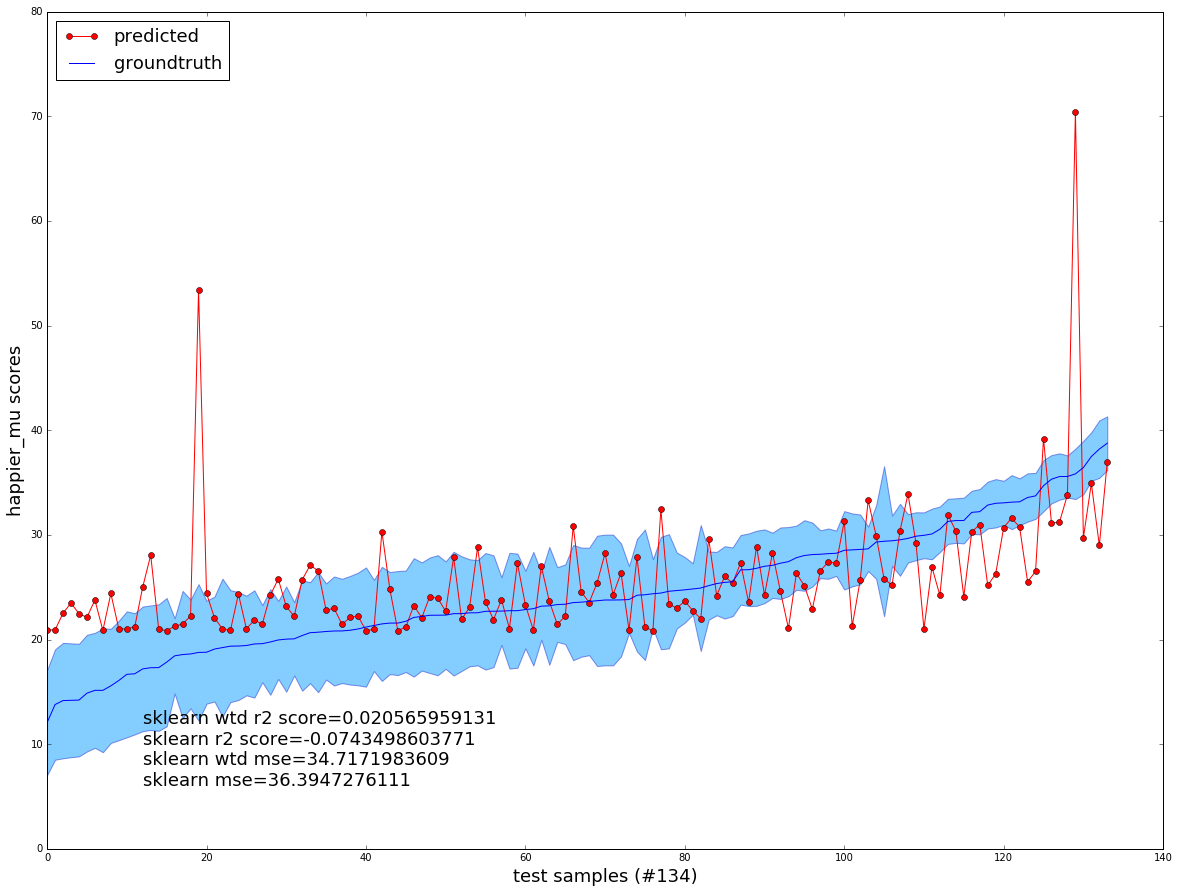

In [22]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)

plt.errorbar(x,y_all_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted[LABEL].values-y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted[LABEL].values+y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted[LABEL].values,fmt='b',label="groundtruth")

#plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(12,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(12,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(12,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(12,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()

In [23]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_trainHot[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_trainHot[LABEL], y_trainHot[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


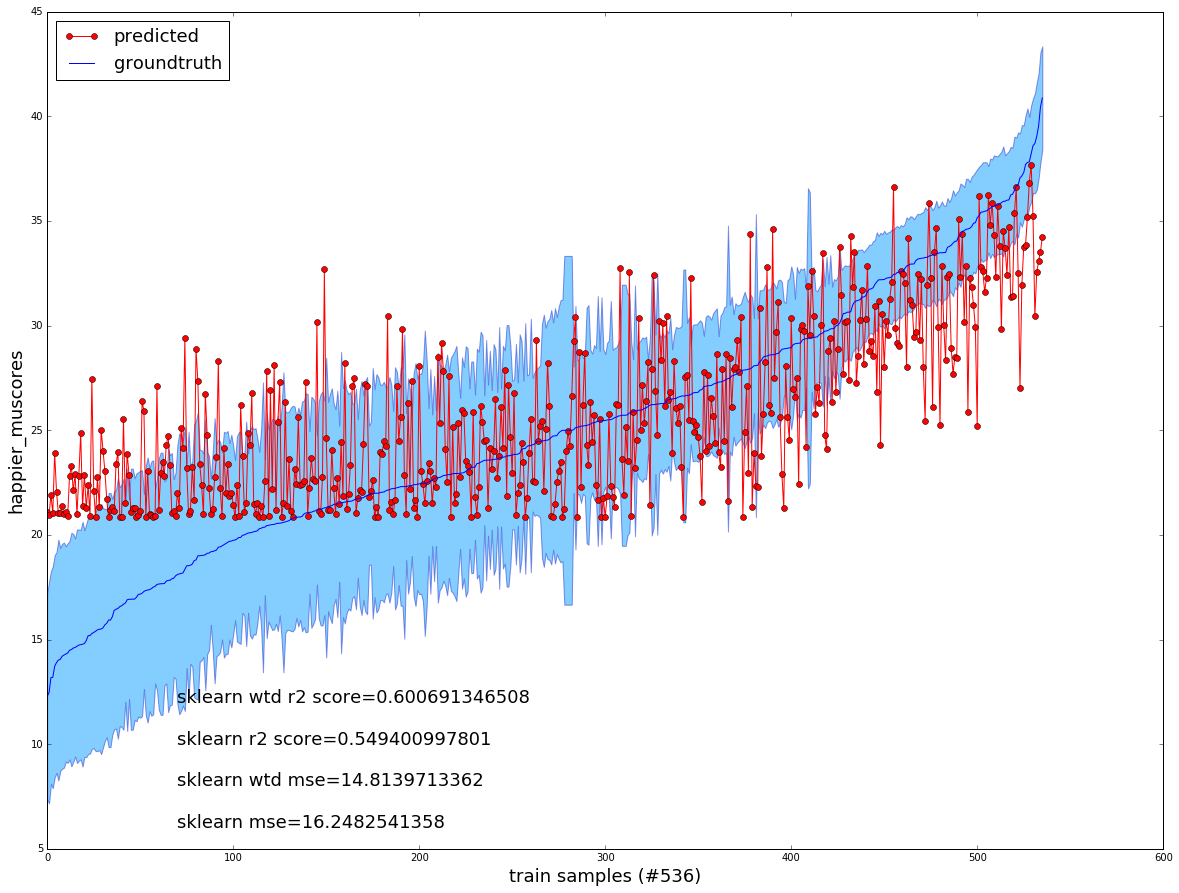

In [24]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)

plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted_train[LABEL].values-y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted_train[LABEL].values+y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted_train[LABEL].values,fmt='b',label="groundtruth")

#plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL + 'scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()